# Zero-shot

In [ ]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
os.environ['OMP_NUM_THREADS'] = '1'
import torch
import time
import json

from utils import data_loader, load_config, inference
import datetime
import wandb
from scplantllm.model import TransformerModel

In [3]:
start_time = time.time()
config = load_config('setting.json')

In [4]:
hyperparameter_defaults = dict(
    parallel=True,
    epochs=1, 
    batch_size=64,
    lr=1e-4,
    ntoken= 185622,
    nctype= 44, 
    nbatch_effect= 238,
    ecs_threshold=0.0, 
    layer_size=512,
    hlayer_size=512,
    nlayers=6,
    nhead=8,
    nlayers_cls=3,
    dropout=0.5,
    schedule_ratio=0.9, 
    save_eval_interval=5,
    fast_transformer=True,
    explicit_zero_prob=False,
    pre_norm=True,
)
current_time = datetime.datetime.now()
timestamp = current_time.strftime("%YY%mM%dD%HH%MM%SS")
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

run = wandb.init(
    config=hyperparameter_defaults,
    project="test",
    entity="aibio",
    group=f"{config.train_strategy}_{config.input_emb_style}",
    mode="offline"
)
model_config = wandb.config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config.input_emb_style == "category":
    n_input_bins = config.n_bins + 2 # pad_value:-2, cls_value:0, masked_value:-1
else:
    n_input_bins = config.n_bins


In [5]:
print("Loading model")
model = TransformerModel(
    ntoken=model_config.ntoken, 
    d_model=model_config.layer_size, 
    nhead=model_config.nhead, 
    d_hid=model_config.hlayer_size,
    nlayers=model_config.nlayers, 
    nlayers_cls=model_config.nlayers_cls, 
    n_cls=model_config.nctype, 
    dropout=model_config.dropout, 
    pad_value=int(config.pad_value),
    pad_token_id=config.pad_token_id, 
    use_batch_labels=config.use_batch_labels, 
    num_batch_labels=model_config.nbatch_effect, 
    input_emb_style=config.input_emb_style, 
    n_input_bins= n_input_bins, 
    cell_emb_style="cls", 
    use_fast_transformer=model_config.fast_transformer, 
    pre_norm=model_config.pre_norm,)

model.to(device)

Loading model


/home/shy/anaconda3/envs/cgs_scplantllm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(185622, 512, padding_idx=0)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): CategoryValueEncoder(
    (embedding): Embedding(103, 512, padding_idx=101)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, e

In [6]:
model_name = f"./model_params/scPlantLLM_model.pth"

try:
    model.load_state_dict(torch.load(model_name))
except:

    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_name)
    pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

In [7]:
data_path = 'data/processed/dont_have_celltype'

In [8]:
test_sampler, test_loader, test_metadata = data_loader(data_path,  data_type='test',start_chunk=1, num_chunks=1, batch_size=model_config.batch_size, append_cls=True)

In [9]:
start_time = time.time()
cell_types_predictions, _, cell_names, probabilities, cell_embeddings, batch_labels_list = inference(model, test_loader, test_metadata, device, config)
predict_end_time = time.time()
print(f"Using time to predict: {predict_end_time - start_time}")

Using time to predict: 162.85403680801392


In [10]:
import pandas as pd
result_df = pd.DataFrame({
        'cell_types_predictions': cell_types_predictions,
        'cell_names': cell_names,
        'batch_labels': batch_labels_list,
        })   

In [11]:
from collections import Counter
import igraph as ig
import leidenalg as la
import random
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import numpy as np

def cluster_umap_embeddings(umap_embeddings, n_neighbors=15, method='leiden', resolution=1.0, random_seed=42):

    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    knn_graph = kneighbors_graph(umap_embeddings, n_neighbors=n_neighbors, include_self=False)

    sources, targets = knn_graph.nonzero()
    edges = list(zip(sources, targets))
    G = ig.Graph(edges=edges, directed=False)

    if method == 'louvain':
        partition = G.community_multilevel()
        labels = np.array(partition.membership)
    elif method == 'leiden':
        partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=resolution, seed=random_seed)
        labels = np.array(partition.membership)
    else:
        raise ValueError("Method must be 'louvain' or 'leiden'")

    silhouette_avg = silhouette_score(umap_embeddings, labels)

    return labels, silhouette_avg


In [12]:
def assign_labels_to_clusters(clusters, true_labels):
    clusters = np.array(clusters)
    true_labels = np.array(true_labels)

    unique_clusters = np.unique(clusters)

    predicted_labels = np.zeros_like(clusters, dtype=object)

    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_labels = true_labels[cluster_indices]
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        predicted_labels[cluster_indices] = most_common_label
    
    return predicted_labels


def cal_cluster(result_df, tsne_embeddings,resolution=0.8, random_seed=42):
    labels, silhouette_avg = cluster_umap_embeddings(tsne_embeddings, n_neighbors=20, method='leiden', resolution=resolution, random_seed=random_seed)
    result_df['leiden_labels'] = labels

    cluster_annotation_label = assign_labels_to_clusters(result_df['leiden_labels'], result_df['cell_types_predictions'])
    result_df['cluster_annotation'] = cluster_annotation_label
    return result_df
    


In [13]:

reducer = TSNE()
tsne_embedding = reducer.fit_transform(cell_embeddings)

In [14]:

result_df = cal_cluster(result_df, tsne_embedding,resolution=0.8, random_seed=42)
result_df

,cell_types_predictions,cell_names,batch_labels,leiden_labels,cluster_annotation
0,13,SRX5025980@@_GGCCTACCCAAG,3,8,13
1,13,SRX5025980@@_GTGCTGCGCAAC,3,8,13
2,13,SRX5025980@@_GTGCTGCGCAAG,3,8,13
3,13,SRX5025980@@_GGTCGCTGTTGA,3,8,13
4,13,SRX5025980@@_GGTCGCTGTTGG,3,8,13
...,...,...,...,...,...
35643,16,SRX5025988@@_CTCATATCAGCG,2,41,16
35644,17,SRX5025988@@_CAGGTGTAATAC,2,5,26
35645,24,SRX5025988@@_CCGTATCTTATT,2,7,20
35646,17,SRX5025988@@_CAACCCTGGCTA,2,23,17


In [15]:
##Plot

In [16]:
import os
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib as mpl


def draw_umap(embedding, cell_types, vocab, color_mapping, title, method='t-SNE', save_name=None, label_clusters=False):  
    
    point_size = 120000 / embedding.shape[0] 

    if not color_mapping:
        raise ValueError("color_mapping cannot be empty or None")

    cell_colors = [color_mapping.get(vocab.get(cell_type, cell_type), '#000000') for cell_type in cell_types]  # 默认颜色为黑色


    label_encoder = LabelEncoder()
    cell_types_encoded = label_encoder.fit_transform(cell_types)
    
    custom_cmap = ListedColormap([color_mapping.get(vocab.get(label, label), '#000000') for label in label_encoder.classes_])

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cell_types_encoded, cmap=custom_cmap, s=point_size)
    
    plt.xlabel(f'{method} 1')
    plt.ylabel(f'{method} 2')
    
    unique_cell_types = label_encoder.classes_
    if vocab:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color_mapping.get(vocab.get(unique_cell_types[i], f'Cell Type {unique_cell_types[i]}'), '#000000'), label=vocab.get(unique_cell_types[i], f'{unique_cell_types[i]}')) for i in range(len(unique_cell_types))]
    else:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color_mapping.get(unique_cell_types[i], '#000000'), label=f'Cluster {unique_cell_types[i]}') for i in range(len(unique_cell_types))]
    
    num_columns = 1 if len(unique_cell_types) <= 40 else (len(unique_cell_types) // 40 + 1)
    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=num_columns)
    
    if label_clusters:
        for cell_type in unique_cell_types:
            mask = np.array(cell_types) == cell_type
            centroid = np.mean(embedding[mask], axis=0)
            plt.annotate(cell_type, centroid, fontsize=14, weight='bold', ha='center', va='center')
    
    plt.grid(False)
    if save_name:
        plt.savefig(f"{save_name}.pdf", dpi=300, format="pdf", bbox_inches='tight')
        print(f"save at {save_name}")
    plt.show()
    

    if save_name:
        fig_legend = plt.figure(figsize=(3, 2))
        plt.legend(handles=handles, loc='center', frameon=False)
        plt.axis('off')
        plt.savefig(f"{save_name}_legend.pdf", dpi=300, format='pdf', bbox_inches='tight')
        print(f"Legend saved at {save_name}_legend.pdf")
        plt.close(fig_legend)
    
    if save_name:
        fig_legend = plt.figure(figsize=(10, 10))
        ax = fig_legend.add_subplot(111)
        ax.axis('off')
        legend = ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=num_columns)
        fig_legend.canvas.draw()
        bbox = legend.get_window_extent().transformed(fig_legend.dpi_scale_trans.inverted())
        fig_legend.savefig(f"{save_name}_figure_legend.pdf", format='pdf', dpi=300, bbox_inches=bbox)
        print(f"Legend saved at {save_name}_legend.pdf")
        plt.close(fig_legend)


In [17]:
nature_colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F',         
                '#8491B4', '#91D1C2', '#DC0000', '#7E6148', '#B09C85',
                '#F7CAC9', '#FE840E', '#FFD700', '#536878', '#996515', 
                 '#804041', '#2F4F4F','#4B0082', '#191970', '#FF00FF', 
                 '#BA55D3', '#9370DB', '#8A2BE2', '#A52A2A', '#DEB887',
                 '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', 
                 '#FFF8DC', '#DC143C', '#00FFFF', '#00008B', '#008B8B', 
                 '#B8860B',  '#006400', '#8B008B', '#556B2F', '#FF8C00',
                 '#9932CC', '#8B0000', '#E9967A', '#8FBC8F', '#483D8B',
                 '#2F4F4F', '#00CED1', '#9400D3', '#FF1493', '#00BFFF',
                 '#1E90FF', '#B22222', '#228B22', '#FFD700']

In [18]:

def create_celltype_color_mapping(celltype_vocab, nature_colors):
    celltype_color_mapping = {}

    for idx, (key, celltype) in enumerate(celltype_vocab.items()):
        color = nature_colors[idx % len(nature_colors)]
        celltype_color_mapping[celltype] = color
    
    return celltype_color_mapping


celltype_vocab_path =f'celltype_vocab.json'
with open(celltype_vocab_path) as f:
        celltype_vocab = json.load(f)
celltype_vocab = {value : key for key, value in celltype_vocab.items()} 
batch_effect_vocab_path =f'data/processed/dont_have_celltype/batch_effect_vocab.meta.json'
with open(batch_effect_vocab_path) as f:
        batch_effect_vocab = json.load(f)
batch_effect_vocab = {value : key for key, value in batch_effect_vocab.items()} 

celltype_color_mapping = create_celltype_color_mapping(celltype_vocab, nature_colors)
batch_effect_vocab_color_mapping = create_celltype_color_mapping(batch_effect_vocab, nature_colors)

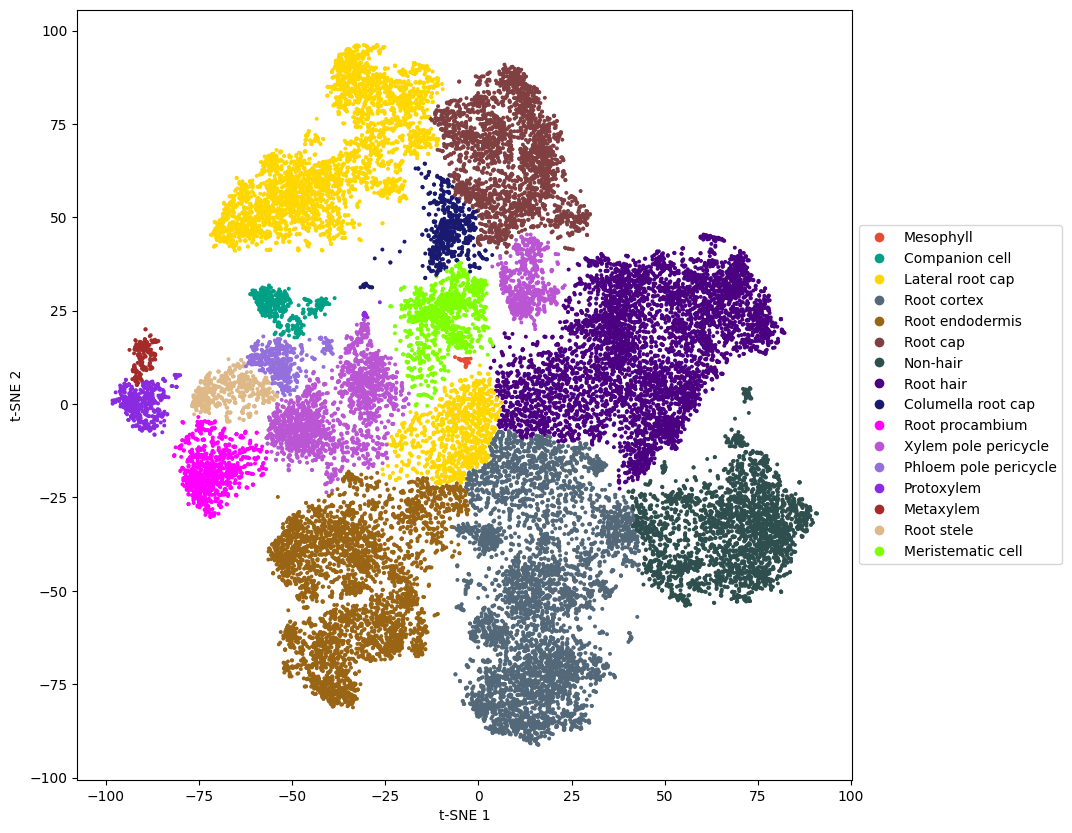

In [19]:
draw_umap(tsne_embedding,  result_df['cluster_annotation'], celltype_vocab, celltype_color_mapping, 'T-SNE', method='t-SNE', label_clusters=False)

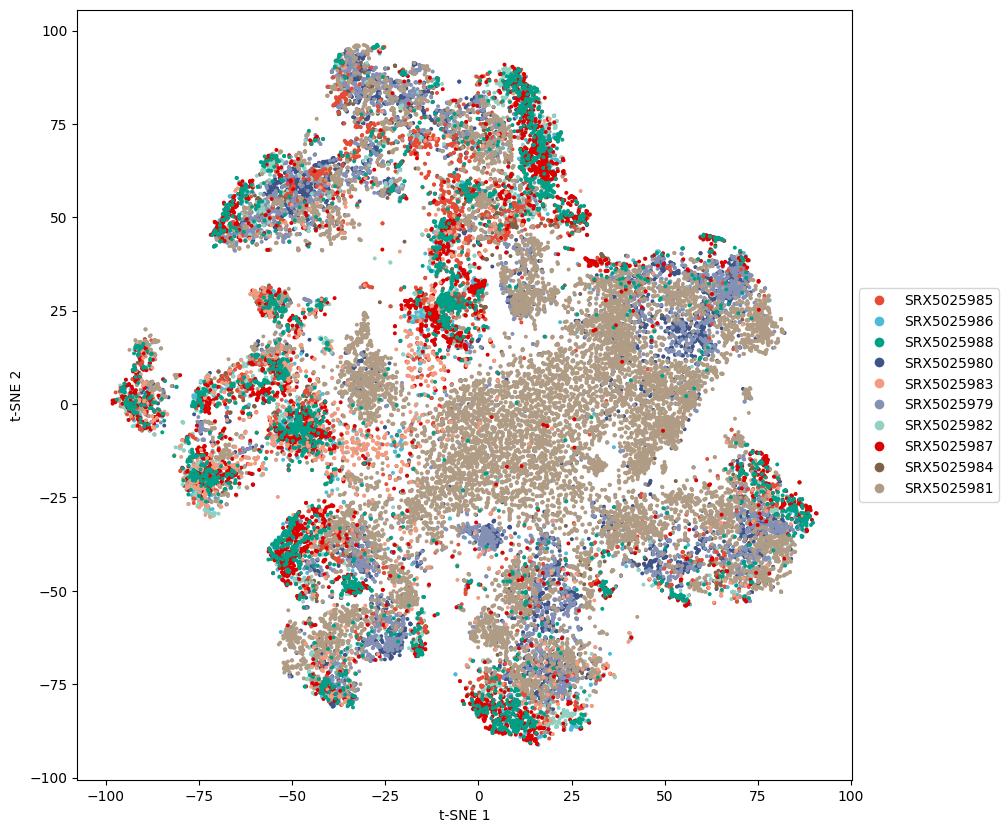

In [20]:
draw_umap(tsne_embedding, result_df['batch_labels'], batch_effect_vocab, batch_effect_vocab_color_mapping, 'T-SNE', method='t-SNE', label_clusters=False)

In [21]:
result_df

,cell_types_predictions,cell_names,batch_labels,leiden_labels,cluster_annotation
0,13,SRX5025980@@_GGCCTACCCAAG,3,8,13
1,13,SRX5025980@@_GTGCTGCGCAAC,3,8,13
2,13,SRX5025980@@_GTGCTGCGCAAG,3,8,13
3,13,SRX5025980@@_GGTCGCTGTTGA,3,8,13
4,13,SRX5025980@@_GGTCGCTGTTGG,3,8,13
...,...,...,...,...,...
35643,16,SRX5025988@@_CTCATATCAGCG,2,41,16
35644,17,SRX5025988@@_CAGGTGTAATAC,2,5,26
35645,24,SRX5025988@@_CCGTATCTTATT,2,7,20
35646,17,SRX5025988@@_CAACCCTGGCTA,2,23,17


In [22]:
result_df['cell_types_predictions'] = result_df['cell_types_predictions'].map(celltype_vocab)
result_df['batch_labels'] = result_df['batch_labels'].map(batch_effect_vocab)
result_df = result_df[['cell_names', 'cell_types_predictions', 'batch_labels']]
result_df

,cell_names,cell_types_predictions,batch_labels
0,SRX5025980@@_GGCCTACCCAAG,Root cortex,SRX5025980
1,SRX5025980@@_GTGCTGCGCAAC,Root cortex,SRX5025980
2,SRX5025980@@_GTGCTGCGCAAG,Root cortex,SRX5025980
3,SRX5025980@@_GGTCGCTGTTGA,Root cortex,SRX5025980
4,SRX5025980@@_GGTCGCTGTTGG,Root cortex,SRX5025980
...,...,...,...
35643,SRX5025988@@_CTCATATCAGCG,Non-hair,SRX5025988
35644,SRX5025988@@_CAGGTGTAATAC,Root hair,SRX5025988
35645,SRX5025988@@_CCGTATCTTATT,Root stele,SRX5025988
35646,SRX5025988@@_CAACCCTGGCTA,Root hair,SRX5025988
